In [1]:
import os
import shutil
import mlflow
from glob import glob
from tqdm import tqdm
import numpy as np
import pandas as pd
import polars as pl
import re
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('tableau-colorblind10')
from IPython.display import display
from scipy import stats

from dotenv import load_dotenv
load_dotenv("../.env")

import sys
sys.path.append("..")
from herec.utils import resultLoader

In [2]:
def labeler(s):

    if s == "HE_MF":
        return "HE-MF"
    if s == "HE_FM":
        return "HE-FM"
    if s == "Ciao_PART":
        return "Ciao$_{PART}$"
    if s == "MF_BPR":
        return "MF-BPR"
    if s == "ProtoMF_BPR":
        return "ProtoMF-BPR"
    if s == "HE_MF_USER_BPR":
        return "HE$_{USER}$-MF-BPR"
    if s == "HE_MF_ITEM_BPR":
        return "HE$_{ITEM}$-MF-BPR"
    if s == "HE_MF_BPR":
        return "HE-MF-BPR"
    if s == "NeuMF_BPR":
        return "NeuMF-BPR"
    if s == "HE_NeuMF_BPR":
        return "HE-NeuMF-BPR"
    if s == "metrics.nDCG_10":
        return "nDCG@10"
    if s == "metrics.HitRate_10":
        return "HitRate@10"
    if s == "metrics.Recall_10":
        return "Recall@10"

    return s

## Get Test Results

In [3]:
experiments = {experiment.experiment_id: experiment.name for experiment in mlflow.search_experiments( view_type="ACTIVE_ONLY" ) if experiment.name.endswith("-TEST")}

df_RESULT = pl.from_pandas(mlflow.search_runs( experiment_ids=experiments.keys() ))
df_RESULT = df_RESULT.select(
    pl.col("experiment_id").replace(experiments, default=None).str.split("-").list.get(0).alias("dataset_name"),
    pl.col("experiment_id").replace(experiments, default=None).str.split("-").list.get(1).alias("model_name"),
    pl.col("params.seed").cast(int),
    pl.col("^metrics(.*?)$").exclude("metrics.TRAIN_LOSS/ROUGH"),
).sort("dataset_name", "model_name")
df_RESULT = df_RESULT.with_columns( np.sqrt(pl.col("metrics.VALID_LOSS")) ) # RMSEに変換

df_RESULT

/home/sugahara/.local/lib/python3.8/site-packages/polars/series/series.py:1223: RuntimeWarning: invalid value encountered in sqrt
  series = f(lambda out: ufunc(*args, out=out, dtype=dtype_char, **kwargs))


dataset_name,model_name,params.seed,metrics.TRAIN_LOSS,metrics.BEST_VALID_LOSS,metrics.VALID_LOSS,metrics.HitRate_30,metrics.Coverage_100,metrics.MRR_50,metrics.Precision_10,metrics.HitRate_50,metrics.nDCG_50,metrics.nDCG_10,metrics.MRR_30,metrics.Precision_30,metrics.Precision_100,metrics.Recall_50,metrics.MRR_10,metrics.Coverage_50,metrics.nDCG_30,metrics.Recall_30,metrics.Coverage_30,metrics.HitRate_10,metrics.MRR_100,metrics.HitRate_100,metrics.Recall_10,metrics.Precision_50,metrics.nDCG_100,metrics.Coverage_10,metrics.Recall_100
str,str,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""Ciao""","""FM""",2,null,null,0.960782,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
"""Ciao""","""FM""",1,null,null,0.942458,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
"""Ciao""","""FM""",0,null,null,1.011424,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
"""Ciao""","""HE_FM""",2,null,null,0.94985,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
"""Ciao""","""HE_FM""",1,null,null,0.936802,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
"""Ciao""","""HE_FM""",0,null,null,0.999538,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
"""Ciao""","""HE_MF""",2,null,null,0.962832,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
"""Ciao""","""HE_MF""",1,null,null,0.93599,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
"""Ciao""","""HE_MF""",0,null,null,0.995068,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null


## Visualization - Explicit

ML100K
ML1M
Ciao
Ciao_PART
Yelp


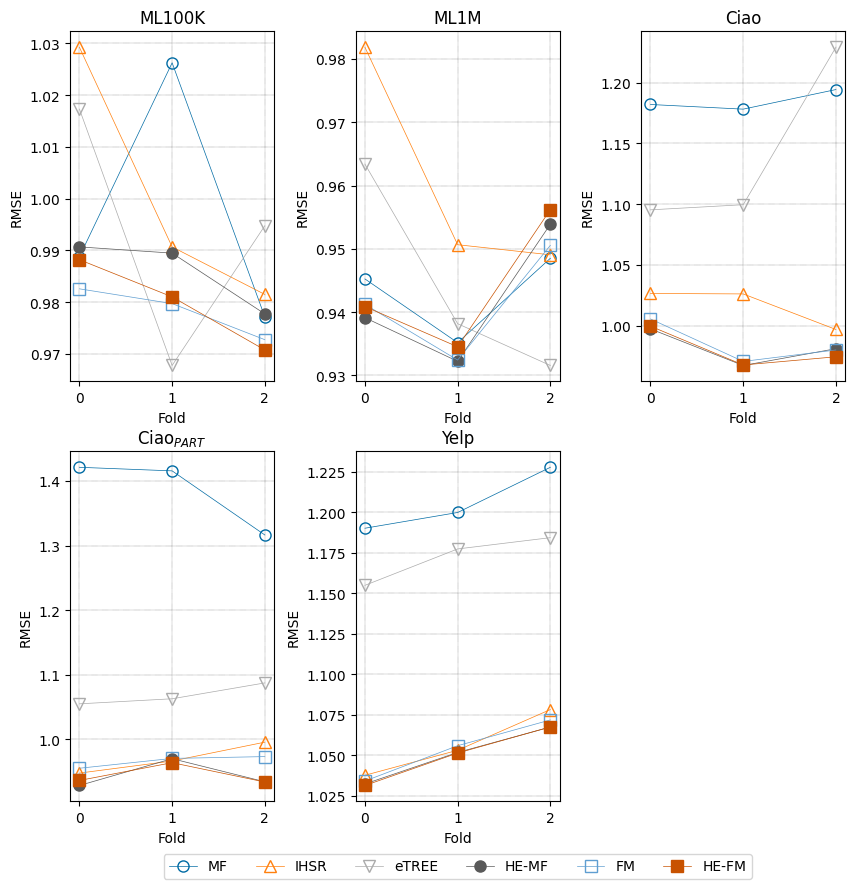

In [4]:
datasetNameList = ["ML100K", "ML1M", "Ciao", "Ciao_PART", "Yelp"]
modelNameList = ["MF", "IHSR", "eTREE", "HE_MF", "FM", "HE_FM"]
markerMap = {
    "MF": "o",
    "IHSR": "^",
    "eTREE": "v",
    "HE_MF": "o",
    "FM": "s",
    "HE_FM": "s",
}

# 可視化
fig, axes = plt.subplots(2, 3, figsize=(10, 10))
plt.subplots_adjust(wspace=0.7, hspace=0.20)

# データセットごとに可視化
for col_i, datasetName in enumerate(datasetNameList):

    print( datasetName )

    ## 絞る
    
    df_TARGET = df_RESULT.filter(
        (pl.col("dataset_name") == datasetName) & pl.col("model_name").is_in(modelNameList)
    ).select(
        pl.all().exclude("^metrics(.*?)$"), np.sqrt(pl.col(f"metrics.VALID_LOSS")).alias("RMSE")
    )
    
    for model_i, modelName in enumerate(modelNameList):
    
        x = df_TARGET.filter( pl.col("model_name") == modelName ).sort("params.seed").get_column("params.seed")
        y = df_TARGET.filter( pl.col("model_name") == modelName ).sort("params.seed").get_column("RMSE")
        axes[col_i//3, col_i%3].plot( x, y, linewidth=0.5, marker=markerMap[modelName], markersize=8, fillstyle=("full" if "HE_" in modelName else "none"), label=labeler(modelName) )
        axes[col_i//3, col_i%3].grid(color='black', linestyle=':', linewidth=0.3)
        axes[col_i//3, col_i%3].set_xlabel("Fold")
        axes[col_i//3, col_i%3].set_ylabel("RMSE")
    
    axes[col_i//3, col_i%3].set_title(labeler(datasetName))
    
axes[1, 1].legend( bbox_to_anchor=(0.5, -0.15), loc='upper center', borderaxespad=0, ncols=len(modelNameList) )
axes[1, 2].set_visible(False)
plt.subplots_adjust(wspace=0.4)
plt.savefig(f"RATING.pdf", bbox_inches='tight')
plt.show()

## Visualization - Implicit

ML100K_IMPLICIT


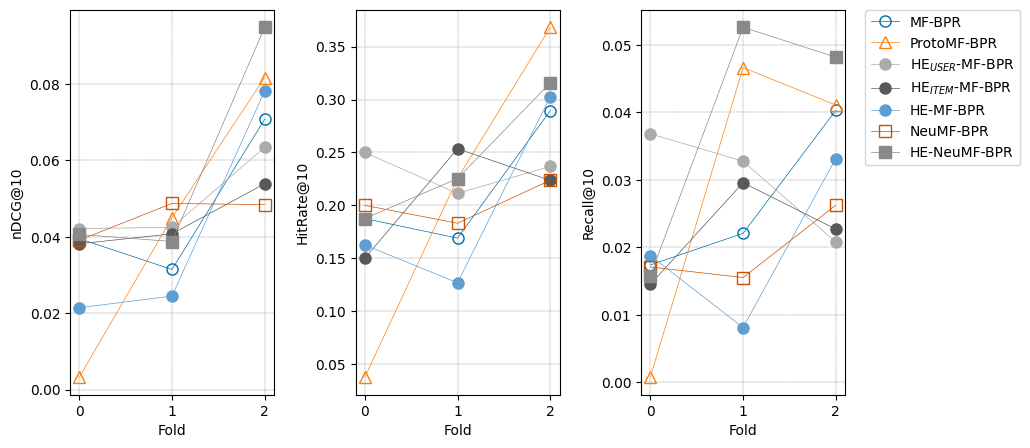

ML1M_IMPLICIT


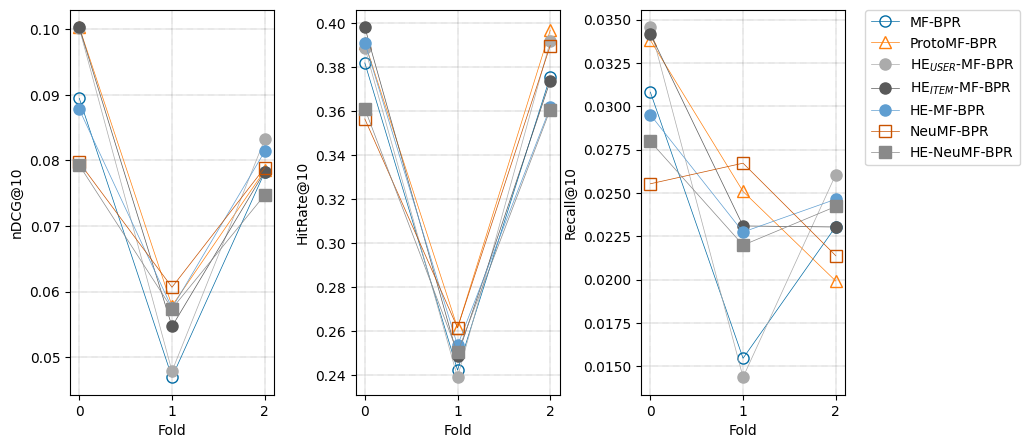

FourSquare


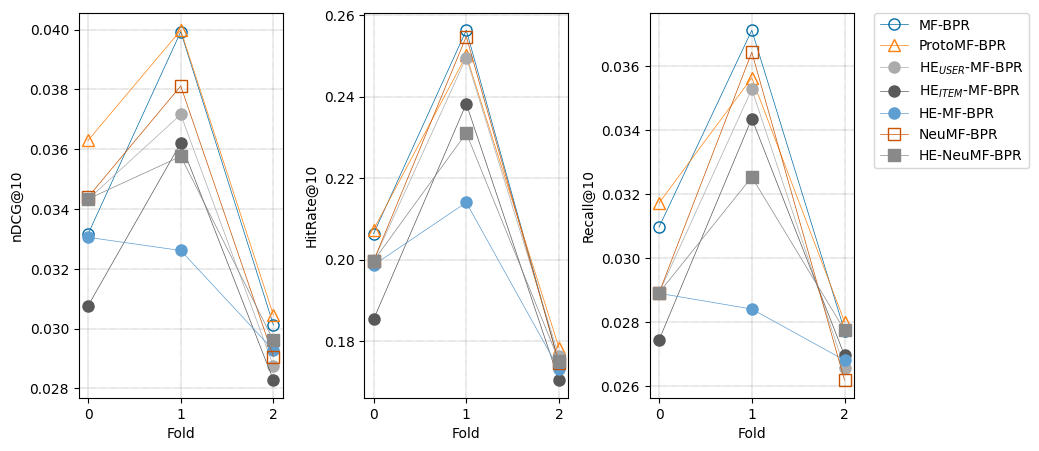

In [5]:
def work():

    datasetNameList = ["ML100K_IMPLICIT", "ML1M_IMPLICIT", "FourSquare"]
    modelNameList = ["MF_BPR", "ProtoMF_BPR", "HE_MF_USER_BPR", "HE_MF_ITEM_BPR", "HE_MF_BPR", "NeuMF_BPR", "HE_NeuMF_BPR"]
    markerMap = {
        "MF_BPR": "o",
        "ProtoMF_BPR": "^",
        "HE_MF_USER_BPR": "o",
        "HE_MF_ITEM_BPR": "o",
        "HE_MF_BPR": "o",
        "NeuMF_BPR": "s",
        "HE_NeuMF_BPR": "s",
    }
    metricMap = { f"{metricName}_{k}": f"{metricName}@{k}" for metricName in ["nDCG", "HitRate", "Recall"] for k in [10] }
    
    # データセットごとに可視化
    for datasetName in datasetNameList:
    
        print( datasetName )
    
        ## 絞る
        
        df_TARGET = df_RESULT.filter(
            (pl.col("dataset_name") == datasetName) & pl.col("model_name").is_in(modelNameList)
        ).select(
            [pl.all().exclude("^metrics(.*?)$")] + [pl.col(f"metrics.{old_name}").alias(new_name) for old_name, new_name in metricMap.items()]
        )
        
        ## 可視化
        
        fig, axes = plt.subplots(1, len(metricMap), figsize=(10, 5))
    
        plt.subplots_adjust(wspace=0.7)
        
        for col_i, metricName in enumerate(metricMap.values()):
        
            for model_i, modelName in enumerate(modelNameList):
            
                x = df_TARGET.filter( pl.col("model_name") == modelName ).sort("params.seed").get_column("params.seed")
                y = df_TARGET.filter( pl.col("model_name") == modelName ).sort("params.seed").get_column(metricName)
                axes[col_i].plot( x, y, linewidth=0.5, marker=markerMap[modelName], markersize=8, fillstyle=("full" if "HE_" in modelName else "none"), label=labeler(modelName) )
                axes[col_i].grid(color='black', linestyle=':', linewidth=0.3)
                axes[col_i].set_xlabel("Fold")
                axes[col_i].set_ylabel(metricName)
        
        axes[-1].legend( bbox_to_anchor=(1.1, 1), loc='upper left', borderaxespad=0 )
        plt.subplots_adjust(wspace=0.4)
        plt.savefig(f"RANKING_{datasetName}.pdf", bbox_inches='tight')
        plt.show()

work()

Twitch100K


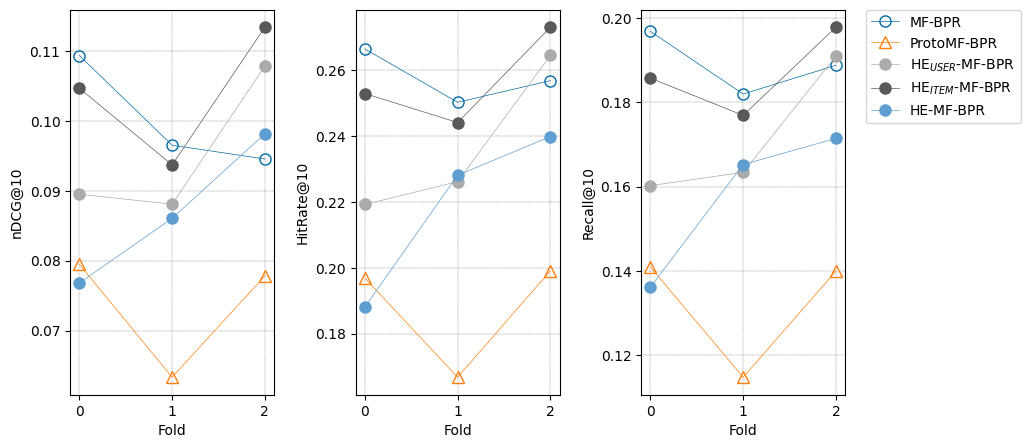

In [6]:
def work():

    datasetNameList = ["Twitch100K"]
    modelNameList = ["MF_BPR", "ProtoMF_BPR", "HE_MF_USER_BPR", "HE_MF_ITEM_BPR", "HE_MF_BPR"]
    markerMap = {
        "MF_BPR": "o",
        "ProtoMF_BPR": "^",
        "HE_MF_USER_BPR": "o",
        "HE_MF_ITEM_BPR": "o",
        "HE_MF_BPR": "o",
        "NeuMF_BPR": "s",
        "HE_NeuMF_BPR": "s",
    }
    metricMap = { f"{metricName}_{k}": f"{metricName}@{k}" for metricName in ["nDCG", "HitRate", "Recall"] for k in [10] }
    
    # データセットごとに可視化
    for datasetName in datasetNameList:
    
        print( datasetName )
    
        ## 絞る
        
        df_TARGET = df_RESULT.filter(
            (pl.col("dataset_name") == datasetName) & pl.col("model_name").is_in(modelNameList)
        ).select(
            [pl.all().exclude("^metrics(.*?)$")] + [pl.col(f"metrics.{old_name}").alias(new_name) for old_name, new_name in metricMap.items()]
        )
        
        ## 可視化
        
        fig, axes = plt.subplots(1, len(metricMap), figsize=(10, 5))
    
        plt.subplots_adjust(wspace=0.7)
        
        for col_i, metricName in enumerate(metricMap.values()):
        
            for model_i, modelName in enumerate(modelNameList):
            
                x = df_TARGET.filter( pl.col("model_name") == modelName ).sort("params.seed").get_column("params.seed")
                y = df_TARGET.filter( pl.col("model_name") == modelName ).sort("params.seed").get_column(metricName)
                axes[col_i].plot( x, y, linewidth=0.5, marker=markerMap[modelName], markersize=8, fillstyle=("full" if "HE_" in modelName else "none"), label=labeler(modelName) )
                axes[col_i].grid(color='black', linestyle=':', linewidth=0.3)
                axes[col_i].set_xlabel("Fold")
                axes[col_i].set_ylabel(metricName)
        
        axes[-1].legend( bbox_to_anchor=(1.1, 1), loc='upper left', borderaxespad=0 )
        plt.subplots_adjust(wspace=0.4)
        plt.savefig(f"RANKING_{datasetName}.pdf", bbox_inches='tight')
        plt.show()

work()

## Table - Explicit

In [7]:
datasetNameList = ["ML100K", "ML1M", "Ciao", "Ciao_PART", "Yelp"]
modelNameList = ["MF", "IHSR", "eTREE", "HE_MF", "FM", "HE_FM"]

for datasetName in datasetNameList:

    print(datasetName)
    
    # Filtering
    df = df_RESULT.filter( (pl.col("dataset_name") == datasetName) & pl.col("model_name").is_in(modelNameList) )
    df = df.select("model_name", "params.seed", np.sqrt(pl.col("metrics.VALID_LOSS")).alias("RMSE")).to_pandas()
    
    # Pivot
    df = df.pivot_table( index="model_name", columns="params.seed", values=["RMSE"] )
    
    # Add Mean Columns
    df[("RMSE", "Ave.")] = df["RMSE"].mean(axis=1)
    
    df = df.loc[modelNameList, :]
    df = df.rename_axis(index=None, columns=["Metric", "Fold"])
    df = df.rename(index=labeler, columns=labeler)
    
    # To Latex
    df = df.round(3).applymap( lambda s: '{:.3f}'.format(s) )
    display(df)
    print(df.to_latex())
    
    print()
    print("**************************************************")
    print()

ML100K


Metric   RMSE                     
Fold        0      1      2   Ave.
MF      0.989  1.026  0.977  0.997
IHSR    1.029  0.991  0.982  1.000
eTREE   1.017  0.968  0.995  0.993
HE-MF   0.991  0.989  0.978  0.986
FM      0.983  0.980  0.973  0.978
HE-FM   0.988  0.981  0.971  0.980

\begin{tabular}{lllll}
\toprule
Metric & \multicolumn{4}{r}{RMSE} \\
Fold & 0 & 1 & 2 & Ave. \\
\midrule
MF & 0.989 & 1.026 & 0.977 & 0.997 \\
IHSR & 1.029 & 0.991 & 0.982 & 1.000 \\
eTREE & 1.017 & 0.968 & 0.995 & 0.993 \\
HE-MF & 0.991 & 0.989 & 0.978 & 0.986 \\
FM & 0.983 & 0.980 & 0.973 & 0.978 \\
HE-FM & 0.988 & 0.981 & 0.971 & 0.980 \\
\bottomrule
\end{tabular}


**************************************************

ML1M


Metric   RMSE                     
Fold        0      1      2   Ave.
MF      0.945  0.935  0.949  0.943
IHSR    0.982  0.951  0.949  0.961
eTREE   0.963  0.938  0.932  0.944
HE-MF   0.939  0.932  0.954  0.942
FM      0.941  0.932  0.951  0.941
HE-FM   0.941  0.935  0.956  0.944

\begin{tabular}{lllll}
\toprule
Metric & \multicolumn{4}{r}{RMSE} \\
Fold & 0 & 1 & 2 & Ave. \\
\midrule
MF & 0.945 & 0.935 & 0.949 & 0.943 \\
IHSR & 0.982 & 0.951 & 0.949 & 0.961 \\
eTREE & 0.963 & 0.938 & 0.932 & 0.944 \\
HE-MF & 0.939 & 0.932 & 0.954 & 0.942 \\
FM & 0.941 & 0.932 & 0.951 & 0.941 \\
HE-FM & 0.941 & 0.935 & 0.956 & 0.944 \\
\bottomrule
\end{tabular}


**************************************************

Ciao


Metric   RMSE                     
Fold        0      1      2   Ave.
MF      1.182  1.178  1.194  1.185
IHSR    1.027  1.026  0.997  1.017
eTREE   1.095  1.100  1.229  1.141
HE-MF   0.998  0.967  0.981  0.982
FM      1.006  0.971  0.980  0.986
HE-FM   1.000  0.968  0.975  0.981

\begin{tabular}{lllll}
\toprule
Metric & \multicolumn{4}{r}{RMSE} \\
Fold & 0 & 1 & 2 & Ave. \\
\midrule
MF & 1.182 & 1.178 & 1.194 & 1.185 \\
IHSR & 1.027 & 1.026 & 0.997 & 1.017 \\
eTREE & 1.095 & 1.100 & 1.229 & 1.141 \\
HE-MF & 0.998 & 0.967 & 0.981 & 0.982 \\
FM & 1.006 & 0.971 & 0.980 & 0.986 \\
HE-FM & 1.000 & 0.968 & 0.975 & 0.981 \\
\bottomrule
\end{tabular}


**************************************************

Ciao_PART


Metric   RMSE                     
Fold        0      1      2   Ave.
MF      1.421  1.416  1.317  1.385
IHSR    0.948  0.966  0.996  0.970
eTREE   1.055  1.063  1.087  1.068
HE-MF   0.929  0.970  0.934  0.944
FM      0.955  0.970  0.973  0.966
HE-FM   0.936  0.964  0.934  0.945

\begin{tabular}{lllll}
\toprule
Metric & \multicolumn{4}{r}{RMSE} \\
Fold & 0 & 1 & 2 & Ave. \\
\midrule
MF & 1.421 & 1.416 & 1.317 & 1.385 \\
IHSR & 0.948 & 0.966 & 0.996 & 0.970 \\
eTREE & 1.055 & 1.063 & 1.087 & 1.068 \\
HE-MF & 0.929 & 0.970 & 0.934 & 0.944 \\
FM & 0.955 & 0.970 & 0.973 & 0.966 \\
HE-FM & 0.936 & 0.964 & 0.934 & 0.945 \\
\bottomrule
\end{tabular}


**************************************************

Yelp


Metric   RMSE                     
Fold        0      1      2   Ave.
MF      1.190  1.200  1.228  1.206
IHSR    1.038  1.053  1.078  1.056
eTREE   1.155  1.177  1.184  1.172
HE-MF   1.032  1.052  1.067  1.051
FM      1.034  1.056  1.072  1.054
HE-FM   1.031  1.051  1.068  1.050

\begin{tabular}{lllll}
\toprule
Metric & \multicolumn{4}{r}{RMSE} \\
Fold & 0 & 1 & 2 & Ave. \\
\midrule
MF & 1.190 & 1.200 & 1.228 & 1.206 \\
IHSR & 1.038 & 1.053 & 1.078 & 1.056 \\
eTREE & 1.155 & 1.177 & 1.184 & 1.172 \\
HE-MF & 1.032 & 1.052 & 1.067 & 1.051 \\
FM & 1.034 & 1.056 & 1.072 & 1.054 \\
HE-FM & 1.031 & 1.051 & 1.068 & 1.050 \\
\bottomrule
\end{tabular}


**************************************************



## Table - Implicit

In [8]:
def work():

    datasetNameList = ["ML100K_IMPLICIT", "ML1M_IMPLICIT", "FourSquare"]
    modelNameList = ["MF_BPR", "ProtoMF_BPR", "HE_MF_USER_BPR", "HE_MF_ITEM_BPR", "HE_MF_BPR", "NeuMF_BPR", "HE_NeuMF_BPR"]
    metricNameList = ["metrics.nDCG_10", "metrics.HitRate_10", "metrics.Recall_10"]
    
    for datasetName in datasetNameList:
    
        print(datasetName)
        
        # Filtering
        df = df_RESULT.filter( (pl.col("dataset_name") == datasetName) & pl.col("model_name").is_in(modelNameList) )
        df = df.select(["model_name", "params.seed"] + metricNameList).to_pandas()
        
        # Pivot
        df = df.pivot_table( index="model_name", columns=["params.seed"], values=metricNameList )
        
        # Add Mean Columns
        for metricName in metricNameList:
            df[(metricName, "Ave.")] = df[metricName].mean(axis=1)
        
        df = df.loc[modelNameList, metricNameList]
        df = df.rename_axis(index=None, columns=["Metric", "Fold"])
        df = df.rename(index=labeler, columns=labeler)
        
        # To Latex
        df = df.round(3).applymap( lambda s: '{:.3f}'.format(s) )
        display(df)
        print(df.to_latex())
    
        print()
        print("**************************************************")
        print()

work()

ML100K_IMPLICIT


Metric             nDCG@10                      HitRate@10                \
Fold                     0      1      2   Ave.          0      1      2   
MF-BPR               0.040  0.031  0.071  0.047      0.188  0.169  0.289   
ProtoMF-BPR          0.003  0.045  0.082  0.043      0.038  0.225  0.368   
HE$_{USER}$-MF-BPR   0.042  0.042  0.063  0.049      0.250  0.211  0.237   
HE$_{ITEM}$-MF-BPR   0.038  0.041  0.054  0.044      0.150  0.254  0.224   
HE-MF-BPR            0.021  0.024  0.078  0.041      0.163  0.127  0.303   
NeuMF-BPR            0.039  0.049  0.048  0.045      0.200  0.183  0.224   
HE-NeuMF-BPR         0.041  0.039  0.095  0.058      0.188  0.225  0.316   

Metric                    Recall@10                       
Fold                 Ave.         0      1      2   Ave.  
MF-BPR              0.215     0.017  0.022  0.040  0.027  
ProtoMF-BPR         0.210     0.001  0.047  0.041  0.030  
HE$_{USER}$-MF-BPR  0.233     0.037  0.033  0.021  0.030  
HE$_{ITEM}$-MF-BPR  0.209     0.015  0.030  0.023  0.022  
HE-MF-BPR           0.197     0.019  0.008  0.033  0.020  
NeuMF-BPR           0.202     0.017  0.016  0.026  0.020  
HE-NeuMF-BPR        0.243     0.016  0.053  0.048  0.039

\begin{tabular}{lllllllllllll}
\toprule
Metric & \multicolumn{4}{r}{nDCG@10} & \multicolumn{4}{r}{HitRate@10} & \multicolumn{4}{r}{Recall@10} \\
Fold & 0 & 1 & 2 & Ave. & 0 & 1 & 2 & Ave. & 0 & 1 & 2 & Ave. \\
\midrule
MF-BPR & 0.040 & 0.031 & 0.071 & 0.047 & 0.188 & 0.169 & 0.289 & 0.215 & 0.017 & 0.022 & 0.040 & 0.027 \\
ProtoMF-BPR & 0.003 & 0.045 & 0.082 & 0.043 & 0.038 & 0.225 & 0.368 & 0.210 & 0.001 & 0.047 & 0.041 & 0.030 \\
HE$_{USER}$-MF-BPR & 0.042 & 0.042 & 0.063 & 0.049 & 0.250 & 0.211 & 0.237 & 0.233 & 0.037 & 0.033 & 0.021 & 0.030 \\
HE$_{ITEM}$-MF-BPR & 0.038 & 0.041 & 0.054 & 0.044 & 0.150 & 0.254 & 0.224 & 0.209 & 0.015 & 0.030 & 0.023 & 0.022 \\
HE-MF-BPR & 0.021 & 0.024 & 0.078 & 0.041 & 0.163 & 0.127 & 0.303 & 0.197 & 0.019 & 0.008 & 0.033 & 0.020 \\
NeuMF-BPR & 0.039 & 0.049 & 0.048 & 0.045 & 0.200 & 0.183 & 0.224 & 0.202 & 0.017 & 0.016 & 0.026 & 0.020 \\
HE-NeuMF-BPR & 0.041 & 0.039 & 0.095 & 0.058 & 0.188 & 0.225 & 0.316 & 0.243 & 0.016 & 0.053 & 0.048 & 0.039 \

Metric             nDCG@10                      HitRate@10                \
Fold                     0      1      2   Ave.          0      1      2   
MF-BPR               0.089  0.047  0.078  0.072      0.382  0.242  0.376   
ProtoMF-BPR          0.100  0.058  0.078  0.079      0.391  0.262  0.397   
HE$_{USER}$-MF-BPR   0.100  0.048  0.083  0.077      0.389  0.239  0.392   
HE$_{ITEM}$-MF-BPR   0.100  0.055  0.078  0.078      0.398  0.249  0.374   
HE-MF-BPR            0.088  0.058  0.081  0.076      0.391  0.254  0.362   
NeuMF-BPR            0.080  0.061  0.079  0.073      0.356  0.262  0.390   
HE-NeuMF-BPR         0.079  0.057  0.075  0.070      0.361  0.250  0.361   

Metric                    Recall@10                       
Fold                 Ave.         0      1      2   Ave.  
MF-BPR              0.333     0.031  0.015  0.023  0.023  
ProtoMF-BPR         0.350     0.034  0.025  0.020  0.026  
HE$_{USER}$-MF-BPR  0.340     0.035  0.014  0.026  0.025  
HE$_{ITEM}$-MF-BPR  0.340     0.034  0.023  0.023  0.027  
HE-MF-BPR           0.336     0.030  0.023  0.025  0.026  
NeuMF-BPR           0.336     0.026  0.027  0.021  0.025  
HE-NeuMF-BPR        0.324     0.028  0.022  0.024  0.025

\begin{tabular}{lllllllllllll}
\toprule
Metric & \multicolumn{4}{r}{nDCG@10} & \multicolumn{4}{r}{HitRate@10} & \multicolumn{4}{r}{Recall@10} \\
Fold & 0 & 1 & 2 & Ave. & 0 & 1 & 2 & Ave. & 0 & 1 & 2 & Ave. \\
\midrule
MF-BPR & 0.089 & 0.047 & 0.078 & 0.072 & 0.382 & 0.242 & 0.376 & 0.333 & 0.031 & 0.015 & 0.023 & 0.023 \\
ProtoMF-BPR & 0.100 & 0.058 & 0.078 & 0.079 & 0.391 & 0.262 & 0.397 & 0.350 & 0.034 & 0.025 & 0.020 & 0.026 \\
HE$_{USER}$-MF-BPR & 0.100 & 0.048 & 0.083 & 0.077 & 0.389 & 0.239 & 0.392 & 0.340 & 0.035 & 0.014 & 0.026 & 0.025 \\
HE$_{ITEM}$-MF-BPR & 0.100 & 0.055 & 0.078 & 0.078 & 0.398 & 0.249 & 0.374 & 0.340 & 0.034 & 0.023 & 0.023 & 0.027 \\
HE-MF-BPR & 0.088 & 0.058 & 0.081 & 0.076 & 0.391 & 0.254 & 0.362 & 0.336 & 0.030 & 0.023 & 0.025 & 0.026 \\
NeuMF-BPR & 0.080 & 0.061 & 0.079 & 0.073 & 0.356 & 0.262 & 0.390 & 0.336 & 0.026 & 0.027 & 0.021 & 0.025 \\
HE-NeuMF-BPR & 0.079 & 0.057 & 0.075 & 0.070 & 0.361 & 0.250 & 0.361 & 0.324 & 0.028 & 0.022 & 0.024 & 0.025 \

Metric             nDCG@10                      HitRate@10                \
Fold                     0      1      2   Ave.          0      1      2   
MF-BPR               0.033  0.040  0.030  0.034      0.206  0.256  0.175   
ProtoMF-BPR          0.036  0.040  0.030  0.036      0.207  0.250  0.178   
HE$_{USER}$-MF-BPR   0.034  0.037  0.029  0.033      0.200  0.250  0.176   
HE$_{ITEM}$-MF-BPR   0.031  0.036  0.028  0.032      0.185  0.238  0.170   
HE-MF-BPR            0.033  0.033  0.029  0.032      0.199  0.214  0.173   
NeuMF-BPR            0.034  0.038  0.029  0.034      0.200  0.255  0.175   
HE-NeuMF-BPR         0.034  0.036  0.030  0.033      0.200  0.231  0.175   

Metric                    Recall@10                       
Fold                 Ave.         0      1      2   Ave.  
MF-BPR              0.212     0.031  0.037  0.028  0.032  
ProtoMF-BPR         0.212     0.032  0.036  0.028  0.032  
HE$_{USER}$-MF-BPR  0.209     0.029  0.035  0.027  0.030  
HE$_{ITEM}$-MF-BPR  0.198     0.027  0.034  0.027  0.030  
HE-MF-BPR           0.195     0.029  0.028  0.027  0.028  
NeuMF-BPR           0.210     0.029  0.036  0.026  0.031  
HE-NeuMF-BPR        0.202     0.029  0.033  0.028  0.030

\begin{tabular}{lllllllllllll}
\toprule
Metric & \multicolumn{4}{r}{nDCG@10} & \multicolumn{4}{r}{HitRate@10} & \multicolumn{4}{r}{Recall@10} \\
Fold & 0 & 1 & 2 & Ave. & 0 & 1 & 2 & Ave. & 0 & 1 & 2 & Ave. \\
\midrule
MF-BPR & 0.033 & 0.040 & 0.030 & 0.034 & 0.206 & 0.256 & 0.175 & 0.212 & 0.031 & 0.037 & 0.028 & 0.032 \\
ProtoMF-BPR & 0.036 & 0.040 & 0.030 & 0.036 & 0.207 & 0.250 & 0.178 & 0.212 & 0.032 & 0.036 & 0.028 & 0.032 \\
HE$_{USER}$-MF-BPR & 0.034 & 0.037 & 0.029 & 0.033 & 0.200 & 0.250 & 0.176 & 0.209 & 0.029 & 0.035 & 0.027 & 0.030 \\
HE$_{ITEM}$-MF-BPR & 0.031 & 0.036 & 0.028 & 0.032 & 0.185 & 0.238 & 0.170 & 0.198 & 0.027 & 0.034 & 0.027 & 0.030 \\
HE-MF-BPR & 0.033 & 0.033 & 0.029 & 0.032 & 0.199 & 0.214 & 0.173 & 0.195 & 0.029 & 0.028 & 0.027 & 0.028 \\
NeuMF-BPR & 0.034 & 0.038 & 0.029 & 0.034 & 0.200 & 0.255 & 0.175 & 0.210 & 0.029 & 0.036 & 0.026 & 0.031 \\
HE-NeuMF-BPR & 0.034 & 0.036 & 0.030 & 0.033 & 0.200 & 0.231 & 0.175 & 0.202 & 0.029 & 0.033 & 0.028 & 0.030 \

In [9]:
def work():

    datasetNameList = ["Twitch100K"]
    modelNameList = ["MF_BPR", "ProtoMF_BPR", "HE_MF_USER_BPR", "HE_MF_ITEM_BPR", "HE_MF_BPR"]
    metricNameList = ["metrics.nDCG_10", "metrics.HitRate_10", "metrics.Recall_10"]
    
    for datasetName in datasetNameList:
    
        print(datasetName)
        
        # Filtering
        df = df_RESULT.filter( (pl.col("dataset_name") == datasetName) & pl.col("model_name").is_in(modelNameList) )
        df = df.select(["model_name", "params.seed"] + metricNameList).to_pandas()
        
        # Pivot
        df = df.pivot_table( index="model_name", columns=["params.seed"], values=metricNameList )
        
        # Add Mean Columns
        for metricName in metricNameList:
            df[(metricName, "Ave.")] = df[metricName].mean(axis=1)
        
        df = df.loc[modelNameList, metricNameList]
        df = df.rename_axis(index=None, columns=["Metric", "Fold"])
        df = df.rename(index=labeler, columns=labeler)
        
        # To Latex
        df = df.round(3).applymap( lambda s: '{:.3f}'.format(s) )
        display(df)
        print(df.to_latex())
    
        print()
        print("**************************************************")
        print()

work()

Twitch100K


Metric             nDCG@10                      HitRate@10                \
Fold                     0      1      2   Ave.          0      1      2   
MF-BPR               0.109  0.097  0.095  0.100      0.266  0.250  0.257   
ProtoMF-BPR          0.079  0.063  0.078  0.074      0.197  0.167  0.199   
HE$_{USER}$-MF-BPR   0.090  0.088  0.108  0.095      0.219  0.226  0.264   
HE$_{ITEM}$-MF-BPR   0.105  0.094  0.113  0.104      0.253  0.244  0.273   
HE-MF-BPR            0.077  0.086  0.098  0.087      0.188  0.228  0.240   

Metric                    Recall@10                       
Fold                 Ave.         0      1      2   Ave.  
MF-BPR              0.258     0.197  0.182  0.189  0.189  
ProtoMF-BPR         0.188     0.141  0.115  0.140  0.132  
HE$_{USER}$-MF-BPR  0.237     0.160  0.163  0.191  0.172  
HE$_{ITEM}$-MF-BPR  0.257     0.186  0.177  0.198  0.187  
HE-MF-BPR           0.219     0.136  0.165  0.171  0.158

\begin{tabular}{lllllllllllll}
\toprule
Metric & \multicolumn{4}{r}{nDCG@10} & \multicolumn{4}{r}{HitRate@10} & \multicolumn{4}{r}{Recall@10} \\
Fold & 0 & 1 & 2 & Ave. & 0 & 1 & 2 & Ave. & 0 & 1 & 2 & Ave. \\
\midrule
MF-BPR & 0.109 & 0.097 & 0.095 & 0.100 & 0.266 & 0.250 & 0.257 & 0.258 & 0.197 & 0.182 & 0.189 & 0.189 \\
ProtoMF-BPR & 0.079 & 0.063 & 0.078 & 0.074 & 0.197 & 0.167 & 0.199 & 0.188 & 0.141 & 0.115 & 0.140 & 0.132 \\
HE$_{USER}$-MF-BPR & 0.090 & 0.088 & 0.108 & 0.095 & 0.219 & 0.226 & 0.264 & 0.237 & 0.160 & 0.163 & 0.191 & 0.172 \\
HE$_{ITEM}$-MF-BPR & 0.105 & 0.094 & 0.113 & 0.104 & 0.253 & 0.244 & 0.273 & 0.257 & 0.186 & 0.177 & 0.198 & 0.187 \\
HE-MF-BPR & 0.077 & 0.086 & 0.098 & 0.087 & 0.188 & 0.228 & 0.240 & 0.219 & 0.136 & 0.165 & 0.171 & 0.158 \\
\bottomrule
\end{tabular}


**************************************************

